In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

mnist = tf.keras.datasets.mnist


## Load MNIST Dataset

In [2]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = (x_train + 0.5).astype(np.int)
print(x_train.shape)

(60000, 28, 28)


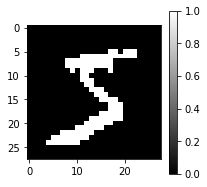

In [3]:
plt.figure(figsize=[3, 3])
plt.imshow(x_train[0], cmap='gray')
plt.colorbar()
plt.show()

## Hyperparameters

In [4]:
N = x_train.shape[0]
Batch = None
Height = 28
Width = 28
Xdim = Height * Width
Hdim = 500
Zdim = 2

## Encoder

In [5]:
def encoder(x, reuse=False):
    with tf.variable_scope('encoder', reuse=reuse):
        h = tf.layers.dense(x, Hdim, activation=tf.nn.relu)
        h = tf.layers.dense(h, Hdim, activation=tf.nn.relu)
        h = tf.layers.dense(h, Hdim, activation=tf.nn.relu)
        z_mean = tf.layers.dense(h, Zdim)
        z_logstd = tf.layers.dense(h, Zdim)
        
    return z_mean, z_logstd

## Decoder

In [6]:
def decoder(z, reuse=False):
    with tf.variable_scope('decoder', reuse=reuse):
        h = tf.layers.dense(z, Hdim, activation=tf.nn.relu)
        h = tf.layers.dense(h, Hdim, activation=tf.nn.relu)
        h = tf.layers.dense(h, Hdim, activation=tf.nn.relu)
        x_logits = tf.layers.dense(h, Xdim)
        
    return x_logits


In [7]:
def safe_log(x):
    return tf.log(tf.maximum(x, 1e-8))


## Draw Graph

In [8]:
tf.reset_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=[Batch, Height * Width])

# encoder : q(z|x)
z_mean, z_logstd = encoder(x)
z_std = tf.exp(z_logstd)
z_var = z_std ** 2

# sample from q(z|x)
z_samples = z_mean + tf.random.normal(tf.shape(z_mean)) * z_std
z_samples = tf.cast(z_samples, tf.float64)

# decoder : p(x|z)
x_logits = decoder(z_samples)
x_probs = tf.nn.sigmoid(x_logits)
x_probs_32 = tf.cast(x_probs, tf.float32)

# find ELBO
likelihood = tf.reduce_sum(x * safe_log(x_probs_32) + (1 - x) * safe_log(1 - x_probs_32), 1)
kl_divergence = 0.5 * tf.reduce_sum(z_mean ** 2 + z_var - safe_log(z_var) - 1, 1)

likelihood = tf.reduce_mean(likelihood)
kl_divergence = tf.reduce_mean(kl_divergence)
ELBO = likelihood - kl_divergence

# optimize
loss = -ELBO
train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

# sampling for test
z_inputs = tf.placeholder(dtype=tf.float64, shape=[Batch, Zdim])
x_samples = decoder(z_inputs, reuse=True)
x_samples = tf.nn.sigmoid(x_samples)

# create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print('done')


done


# Training loop

In [9]:
from scipy.stats import multivariate_normal

def get_data(batch_size):
    indexes = np.random.randint(0, len(x_train), batch_size)
    _x = x_train[indexes]
    _x = np.reshape(_x, [_x.shape[0], -1])
    
    return _x

'''
prior distribution N(0, I)에서 _zs값들의 likelihood를 계산하여 리턴
'''
def get_log_prior(_zs, z_min, z_max):
    
    _log_prior = multivariate_normal.logpdf(_zs, mean=[0, 0], cov=[1, 1])
    _log_prior = np.reshape(_log_prior, [100, 100])
    
    return _log_prior

'''
_zs값들을 decoder에 통과시킨 후 나온 multivariate bernoulli distribution에 대한 _x의 likelihood 값을 계산하여 리턴
'''
def get_log_likelihood(_zs, _x):
    
    _x_samples = sess.run(x_samples, feed_dict={z_inputs: _zs})
    _x_samples = np.reshape(_x_samples, [-1, 28, 28])
    _positive = _x_samples * _x

    _n_x_samples = 1. - _x_samples
    _negative = _n_x_samples * (1. - _x)
    
    _likelihood = _positive + _negative
    _log_likelihood = np.log(_likelihood)

    _log_likelihood = np.sum(np.sum(_log_likelihood, axis=1), axis=1)
    _log_likelihood = np.reshape(_log_likelihood, [100, 100])
    
    return _log_likelihood

'''
log prior와 log likelihood를 받아 log posterior를 리턴, p(z|x) ∝ p(x) * p(x|z)
'''
def get_true_log_posterior(_log_prior, _log_likelihood):

    return _log_prior + _log_likelihood

'''
input _x에 대해 z space에서 variational log posterior 값을 계산하여 리턴
'''    
def get_variational_log_posterior(_zs, _x):
    
    _z_mean, _z_var = sess.run([z_mean, z_var], feed_dict={x: np.reshape(_x, [1, -1])})
    _log_posterior = multivariate_normal.logpdf(_zs, mean=_z_mean[0], cov=_z_var[0])
    _log_posterior = np.reshape(_log_posterior, [100, 100])
    
    return _log_posterior


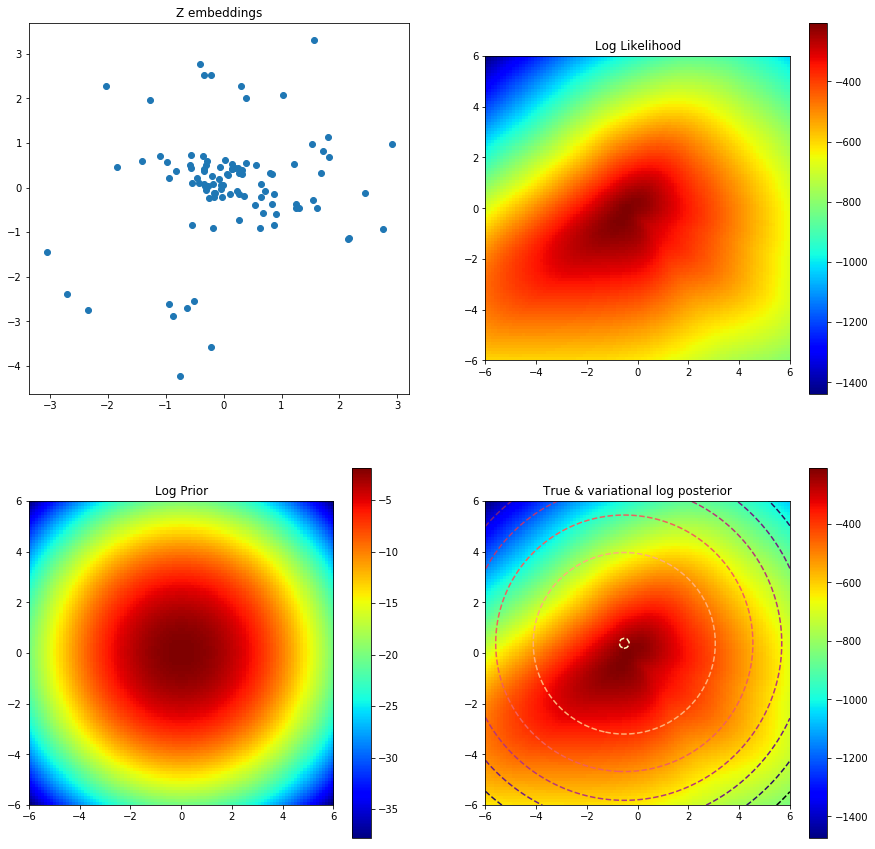

In [10]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

Epoch = 5
Batch_size = 100

for _ in range(Epoch):
    
    for _ in tqdm(range(500)):
        
        _x = get_data(Batch_size)
        _, _loss, _z_samples = sess.run([train_step, loss, z_samples], feed_dict={x: _x})
        #print('loss : ', _loss)
        
    clear_output()
    
    z_min = -6
    z_max = 6
    
    # z1, z2 samples from [z_min, z_max]
    _z1, _z2 = np.meshgrid(np.linspace(z_min, z_max, 10), np.linspace(z_min, z_max, 10))
    _z = np.concatenate([_z1[:, :, None], _z2[:, :, None]], axis=-1)
    _z = np.reshape(_z, [100, 2])
    
    # x samples
    _x_samples = sess.run(x_samples, feed_dict={z_inputs: _z})
    _x_samples = np.clip(_x_samples, 0., 1.)
    _x_samples = np.reshape(_x_samples, [100, Height, Width])
    
    
    fig, ax = plt.subplots(2, 2, figsize=[15, 15])
    
    ax[0, 0].set_title('Z embeddings')
    ax[0, 0].scatter(_z_samples[:, 0], _z_samples[:, 1])
    
    '''
    z-space z1, z2축을 기준으로 [z_min, z_max] 범위에서 100개씩 값을 뽑아 총 10,000개의 point를 가진 meshgrid를 만듬
    '''
    _z1, _z2 = np.meshgrid(np.linspace(z_min, z_max, 100), np.linspace(z_min, z_max, 100))
    _zs = np.concatenate([_z1[:, :, None], _z2[:, :, None]], axis=-1)
    _zs = np.reshape(_zs, [10000, 2])

    '''
    likelihood를 구할 input으로 x_train[0]를 선택
    '''
    _x = x_train[0]
    
    ax[1, 0].set_title('Log Prior')
    _log_prior = get_log_prior(_zs, z_min, z_max)
    im = ax[1, 0].imshow(_log_prior, extent=[z_min, z_max, z_min, z_max], cmap=cm.jet)
    fig.colorbar(im, ax=ax[1, 0])
    
    ax[0, 1].set_title('Log Likelihood')
    _log_likelihood = get_log_likelihood(_zs, _x)
    im = ax[0, 1].imshow(_log_likelihood, extent=[z_min, z_max, z_min, z_max], cmap=cm.jet)
    fig.colorbar(im, ax=ax[0, 1])
    
    ax[1, 1].set_title('True & variational log posterior')
    _true_log_posterior = get_true_log_posterior(_log_prior, _log_likelihood)
    im = ax[1, 1].imshow(_true_log_posterior, extent=[z_min, z_max, z_min, z_max], cmap=cm.jet)
    fig.colorbar(im, ax=ax[1, 1])
    
    _variational_log_posterior = get_variational_log_posterior(_zs, _x)
    
    cont = ax[1, 1].contour(_z1, _z2, _variational_log_posterior, 
                extent=[z_min, z_max, z_min, z_max], cmap=cm.magma, linestyles='dashed')
    
    plt.show()
    